In [79]:
# %matplotlib notebook
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display,clear_output
import multiprocessing
import time
from matplotlib.patches import Rectangle
import os, shutil
import cv2

In [80]:
class Unit:
    def __init__(
        self, field, swarm, x, y, pheremone_strength, speed, power, attack_range
    ):
        #Position
        self.x = x
        self.y = y

    
        self.swarm = swarm #swarm_id

        self.field = field #field data

        self.health = 10

        #what we are evolving
        self.attack_range = attack_range
        self.speed = speed
        self.power = power
        self.pheremone_strength = pheremone_strength

        #Stats
        self.kill_count = 0
        self.time_alive = 0
        self.food_returned_count = 0
        self.score = 0
        self.has_food = False

        self.heading = random.randint(0, 359) # we can make this an evolving param too
    def get_score(self):
        return self.score
    
    def reset(self, x, y):
        self.x = x
        self.y = y

        self.health = 10

        # Stats
        self.kill_count = 0
        self.time_alive = 0
        self.food_returned_count = 0

        self.score = 0
        self.has_food = False

        self.heading = random.randint(0, 359)
    #goes to nest oncw has food
    def uphill_nest_scent(self):
        if self.swarm == 0:
            try:
                scent_ahead = self.field.patch_ahead(
                    self.x, self.y, self.heading
                ).nest1_scent
            except:
                scent_ahead = 0
            try:
                scent_right = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, 45
                ).nest1_scent
            except:
                scent_right = 0
            try:
                scent_left = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, -45
                ).nest1_scent
            except:
                scent_left = 0

            if scent_right > scent_ahead or scent_left > scent_ahead:
                if scent_right > scent_left:
                    self.heading += 45
                else:
                    self.heading -= 45
        else:
            try:
                scent_ahead = self.field.patch_ahead(
                    self.x, self.y, self.heading
                ).nest2_scent
            except:
                scent_ahead = 0
            try:
                scent_right = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, 45
                ).nest2_scent
            except:
                scent_right = 0
            try:
                scent_left = self.field.patch_right_and_ahead(
                    self.x, self.y, self.heading, -45
                ).nest2_scent
            except:
                scent_left = 0
            if scent_right > scent_ahead or scent_left > scent_ahead:
                if scent_right > scent_left:
                    self.heading += 45
                else:
                    self.heading -= 45

    def search_for_food(self):
        if self.field.patch_here(self.x, self.y) != None:
            if self.field.patch_here(self.x, self.y).food > 0:
                self.has_food = True
                self.field.patch_here(self.x, self.y).food -= 1
                self.field.total_food -= 1
        else:
            if self.swarm == 0:
                try:
                    pheromone_ahead = self.field.patch_ahead(
                        self.x, self.y, self.heading
                    ).pheremone_1
                except:
                    pheromone_ahead = 0
                try:
                    pheromone_right = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, 45
                    ).pheremone_1
                except:
                    pheromone_right = 0
                try:
                    pheromone_left = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, -45
                    ).pheremone_1
                except:
                    pheromone_left = 0
            else:
                try:
                    pheromone_ahead = self.field.patch_ahead(
                        self.x, self.y, self.heading
                    ).pheremone_2
                except:
                    pheromone_ahead = 0
                try:
                    pheromone_right = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, 45
                    ).pheremone_2
                except:
                    pheromone_right = 0
                try:
                    pheromone_left = self.field.patch_right_and_ahead(
                        self.x, self.y, self.heading, -45
                    ).pheremone_2
                except:
                    pheromone_left = 0


            # Choose the direction with the highest pheromone concentration
            if pheromone_right > pheromone_ahead and pheromone_right > pheromone_left:
                self.heading += 45
            elif pheromone_left > pheromone_ahead and pheromone_left > pheromone_right:
                self.heading -= 45

    def return_to_nest(self):
        if self.swarm == 0:
            if self.field.patch_here(self.x, self.y).nest1:
                self.has_food = False
                self.heading += 180
                self.field.swarms[0].food_count +=1
                self.food_returned_count += 1
            else:
                self.field.patch_here(
                    self.x, self.y
                ).pheremone_1 += self.pheremone_strength

                calc_range = math.ceil(-3.5 * math.log(1 / self.pheremone_strength))
                for dx in range(-calc_range, calc_range + 1):
                    for dy in range(-calc_range, calc_range + 1):
                        new_x = self.x + dx
                        new_y = self.y + dy
                        if 0 <= new_x < self.field.width and 0 <= new_y < self.field.height:
                            # Calculate distance from the turtle's current position to the patch
                            distance_to_patch = math.sqrt(dx ** 2 + dy ** 2)
                            # Calculate decayed pheromone strength based on distance
                            decayed_strength = self.pheremone_strength * math.exp(-distance_to_patch / 2)  # Adjust decay rate as needed
                            self.field.patch_here(new_x, new_y).pheremone_1 += decayed_strength

                self.uphill_nest_scent()
        else:
            if self.field.patch_here(self.x, self.y).nest2:
                self.has_food = False
                self.heading += 180
                self.field.swarms[1].food_count +=1
                self.food_returned_count +=1
            else:
                self.field.patch_here(
                    self.x, self.y
                ).pheremone_2 += self.pheremone_strength

                calc_range = math.ceil(-3.5 * math.log(1 / self.pheremone_strength))
                for dx in range(-calc_range, calc_range + 1):
                    for dy in range(-calc_range, calc_range + 1):
                        new_x = self.x + dx
                        new_y = self.y + dy
                        if 0 <= new_x < self.field.width and 0 <= new_y < self.field.height:
                            # Calculate distance from the turtle's current position to the patch
                            distance_to_patch = math.sqrt(dx ** 2 + dy ** 2)
                            # Calculate decayed pheromone strength based on distance
                            decayed_strength = self.pheremone_strength * math.exp(-distance_to_patch / 3.5)  # Adjust decay rate as needed
                            self.field.patch_here(new_x, new_y).pheremone_2 += decayed_strength

                self.uphill_nest_scent()

    def move(self):
        if self.health>0:
            if self.has_food:
                self.return_to_nest()
            else:
                self.search_for_food()

            self.heading += random.randint(-30, 30)
            self.forward()
            self.time_alive += 1

    def forward(self):

        new_x = self.x + math.cos(math.radians(self.heading)) * self.speed
        new_y = self.y + math.sin(math.radians(self.heading)) * self.speed
        while (
            new_x < 0
            or new_x > self.field.width
            or new_y < 0
            or new_y > self.field.height
        ):
            new_x = self.x - math.cos(math.radians(self.heading)) * self.speed
            new_y = self.y - math.sin(math.radians(self.heading)) * self.speed
            self.heading += random.randint(-40, 40)
            new_x = self.x + math.cos(math.radians(self.heading)) * self.speed
            new_y = self.y + math.cos(math.radians(self.heading)) * self.speed
        self.x = new_x
        self.y = new_y

    def attack(self):
        enemies = self.field.swarms[not self.swarm]
        for enemy_num in random.sample(enemies.active_units, len(enemies.active_units)):
            enemy = enemies.all_units[enemy_num]
            if enemy != self:
                distance = math.sqrt((self.x - enemy.x) ** 2 + (self.y - enemy.y) ** 2)
                if distance <= self.attack_range:
                    enemy.health -= self.power
                    if enemy.health <= 0:
                        self.kill_count += 1
                    break
    def normalize(self, value, min_value, max_value):
        return (value - min_value) / (max_value - min_value) if max_value != min_value else 0

    def eval(self,minvals,maxvals):
        normalized_food_returned_count = self.normalize(
            self.food_returned_count, minvals["food_returned_count"], maxvals["food_returned_count"]
        )
        normalized_kill_count = self.normalize(
            self.kill_count, minvals["kill_count"], maxvals["kill_count"]
        )
        normalized_time_alive = self.normalize(
            self.time_alive, minvals["time_alive"], maxvals["time_alive"]
        )

        if self.swarm == 0:
            self.score = (.6 * normalized_food_returned_count) + (.2 * normalized_kill_count) + (.2 *normalized_time_alive)
        else:
            self.score = (.2 * normalized_food_returned_count) + (.2 * normalized_kill_count) + (.6 *normalized_time_alive)

        # implement logic upon unit death

In [81]:
class Swarm:

    def __init__(self, field, id, max_units, start_x, start_y, elites):
        self.id = id
        self.max_units = max_units
        self.field = field
        self.all_units = []
        self.active_units = []
        self.dead_units = []
        self.pheromone_map = (field.width, field.height)
        self.x = start_x
        self.y = start_y
        self.elites = elites
        self.food_count = 0
        self.wins=[]
        self.swarm_stats = []

        self.populate_swarm()

    def book_keeping(self):
        stats_dict = {
            "Attack Range": 0,
            "Speed": 0,
            "Power": 0,
            "Pheremone Strength": 0,
        }

        for ant in self.all_units:
            stats_dict["Attack Range"] += ant.attack_range
            stats_dict["Speed"] += ant.speed
            stats_dict["Power"] += ant.power
            stats_dict["Pheremone Strength"] += ant.pheremone_strength

        stats_dict.update((x, y / len(self.all_units)) for x, y in stats_dict.items())

        for key, val in stats_dict.items():
            print(f"Average {key}: {val}")

        self.swarm_stats.append(stats_dict)

    def processing_move(unit):
        unit.move()

    def gene_pool(self):
        pool = []
        for elite in self.elites:
            pool.append(
                [elite.speed, elite.power, elite.attack_range, elite.pheremone_strength]
            )
        return pool

    def update_and_reset(self):
        self.active_units = []
        self.dead_units = []
        self.food_count = 0
        i = 0
        for ant in self.all_units:
            # Select a random elite from the gene pool
            ant.reset(self.x, self.y)

            elite_index = random.randint(0, 4)
            # print(type(self.elites))
            # elite = self.elites[elite_index]
            pool = self.gene_pool()
            # Choose a random attribute to modify
            gene = random.randint(0, 3)

            # Modify the selected attribute with some randomness
            if gene == 0:  # Modify speed
                ant.speed = pool[elite_index][gene] * random.uniform(0.90, 1.10)

            elif gene == 1:  # Modify power

                ant.power = pool[elite_index][gene] + random.randint(-1, 1)

            elif gene == 2:  # Modify attack_range

                ant.attack_range = pool[elite_index][gene] * random.uniform(0.90, 1.10)

            else:  # Modify p_strength

                ant.pheremone_strength = pool[elite_index][gene] + random.randint(-1, 1)

            self.active_units.append(i)
            i += 1

    def populate_swarm(self):
        for i in range(self.max_units):
            speed = random.uniform(0.5, 1.5)
            power = random.randint(1, 5)
            attack_range = random.uniform(0.5, 3)
            p_strength = random.randint(5, 20)
            ant = Unit(
                self.field,
                self.id,
                self.x,
                self.y,
                p_strength,
                speed,
                power,
                attack_range,
            )
            self.all_units.append(ant)
            self.active_units.append(i)

    # populate swarm and initialize random stats for each unit

    def check_death(self):
        for unit in self.active_units:
            if self.all_units[unit].health <= 0:
                self.active_units.remove(unit)
                self.dead_units.append(unit)

    def eval_swarm(self):

        max_values = {
            "food_returned_count": float("-inf"),
            "kill_count": float("-inf"),
            "time_alive": float("-inf"),
        }
        min_values = {
            "food_returned_count": float("inf"),
            "kill_count": float("inf"),
            "time_alive": float("inf"),
        }

        # Iterate through units to find max and min values
        for unit in self.all_units:
            max_values["food_returned_count"] = max(
                max_values["food_returned_count"], unit.food_returned_count
            )
            max_values["kill_count"] = max(max_values["kill_count"], unit.kill_count)
            max_values["time_alive"] = max(max_values["time_alive"], unit.time_alive)

            min_values["food_returned_count"] = min(
                min_values["food_returned_count"], unit.food_returned_count
            )
            min_values["kill_count"] = min(min_values["kill_count"], unit.kill_count)
            min_values["time_alive"] = min(min_values["time_alive"], unit.time_alive)

        for ant in self.all_units:
            ant.eval(min_values, max_values)

        # Sort the array of live ants based on their scores (in descending order)
        sorted_swarm = sorted(self.all_units, key=lambda x: x.score, reverse=True)
        # Select the top 5 ants as elites
        elites = sorted_swarm[:5]

        # ADDED
        if len(elites) < 5:
            print("problem")
            exit(0)

        return elites

    def print_stats(self):
        for elite in self.elites:
            print(
                f"speed- {elite.speed} power- {elite.power} p_strength- {elite.pheremone_strength} range- {elite.attack_range} time alive- {elite.time_alive} food collected-{elite.food_returned_count} kill count-{elite.kill_count} "
            )

    def update(self):
        # Implement any other updates for the swarm i cant think of anything but here is extra stuff
        pass

In [82]:
class Patch:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.pheremone_1 = 0
        self.pheremone_2 = 0
        self.food = 0
        self.nest1 = False
        self.nest2 = False
        self.nest1_scent = 0
        self.nest2_scent = 0
        self.food_source_number = 0
        self.rect = None

In [83]:
class Battlefield:
    def __init__(self, width, height,units):
        self.width = width
        self.height = height
        # ADDED
        self.total_food = 0

        # not being used
        self.resource_nodes = []
        self.swarms = []
        self.red_stats = []
        self.blue_stats = []
        self.elite_fitness1 = []
        self.elite_fitness2 = []

        self.swarm_results = {
            "swarm_1": {
                "food_returned_count": [],
                "kill_count": [],
                "time_alive": [],
            },
            "swarm_2": {
                "food_returned_count": [],
                "kill_count": [],
                "time_alive": [],
            },
        }

        self.tick_count = 0
        self.evolution = 0

        self.swarms.append(Swarm(self, 0, units, 0, self.height / 2, []))
        self.swarms.append(Swarm(self, 1, units, self.width, self.height / 2, []))

        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(0, width)
        self.ax.set_ylim(0, height)
        self.sc1 = self.ax.scatter([], [], color=["red"], label=["Class 1"])
        self.sc2 = self.ax.scatter([], [], color=["blue"], label=["Class 2"])

        self.patches = [[Patch(x, y) for y in range(height)] for x in range(width)] #making 1x1 blocks over the map
        self.populate_resources()
    
    def book_keeping(self, swarm, team):
        stats_dict = {'Attack Range': 0, 'Speed': 0, 'Power': 0, 'Pheremone Strength': 0}

        for ant in swarm.all_units:
            stats_dict['Attack Range'] += ant.attack_range
            stats_dict['Speed'] += ant.speed
            stats_dict['Power'] += ant.power
            stats_dict['Pheremone Strength'] += ant.pheremone_strength
        
        stats_dict.update((x, y / len(swarm.all_units)) for x, y in stats_dict.items())

        for key, val in stats_dict.items():
            print(f'Average {key}: {val}')
        
        if team == 'Red':
            self.red_stats.append(stats_dict)
        else:
            self.blue_stats.append(stats_dict)
    
    
    # ADDED
    def reset(self, elites0, elites1):

        #self.swarms = []
        self.tick_count = 0
        self.total_food = 0

        # update swarms
        # pass elites to function to amplify swarm stats
        # self.swarms.append(Swarm(self, 0, 50, 0, self.height / 2, elites0))
        # self.swarms.append(Swarm(self, 1, 50, self.width, self.height / 2, elites1))
        self.swarms[0].elites= elites0
        self.swarms[1].elites= elites1
        self.swarms[0].update_and_reset()
        self.swarms[1].update_and_reset()
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(0, self.width)
        self.ax.set_ylim(0, self.height)
        self.sc1 = self.ax.scatter([], [], color=["red"], label=["Class 1"])
        self.sc2 = self.ax.scatter([], [], color=["blue"], label=["Class 2"])

        self.patches = [
            [Patch(x, y) for y in range(self.height)] for x in range(self.width)
        ]  # making 1x1 blocks over the map
        self.populate_resources()
        

    def setup_nest(self, patch: Patch):
        if math.sqrt((patch.x - 0) ** 2 + (patch.y - self.height / 2) ** 2) < 2:
            patch.nest1 = True
        patch.nest1_scent = 200 - math.sqrt(
            (patch.x - 0) ** 2 + (patch.y - self.height / 2) ** 2
        )
        if (
            math.sqrt((patch.x - (self.width-1)) ** 2 + (patch.y - self.height / 2) ** 2)
            < 2
        ):
            patch.nest2 = True
        patch.nest2_scent = 200 - math.sqrt(
            (patch.x - (self.width-1)) ** 2 + (patch.y - self.height / 2) ** 2
        )

    def setup_food(self, patch):
        if (
            math.sqrt(
                (patch.x - 0.6 * self.width) ** 2 + (patch.y - 0.2 * self.height) ** 2
            )
            < 7
        ):
            patch.food_source_number = 1
        elif (
            math.sqrt(
                (patch.x - 0.4 * self.width) ** 2 + (patch.y - 0.8 * self.height) ** 2
            )
            < 7
        ):
            patch.food_source_number = 2
        # elif (
        #     math.sqrt(
        #         (patch.x - 0.8 * self.width) ** 2 + (patch.y - 0.8 * self.height) ** 2
        #     )
        #     < 5
        # ):
        #     patch.food_source_number = 3
        if patch.food_source_number > 0:
            patch.food =1 #random.choice([1, 2])

    def patch_here(self, x, y):
        if 0 <= x < self.width and 0 <= y < self.height:
            return self.patches[int(x)][int(y)]
        return None

    def patch_ahead(self, x, y, heading):
        dx = math.cos(math.radians(heading))
        dy = math.sin(math.radians(heading))
        return self.patch_here(x + dx, y + dy)

    def patch_right_and_ahead(self, x, y, heading, angle):
        dx = math.cos(math.radians(heading + angle))
        dy = math.sin(math.radians(heading + angle))
        return self.patch_here(x + dx, y + dy)

    def populate_resources(self):
        for x in range(self.width):
            for y in range(self.height):
                self.setup_nest(self.patches[x][y])
                self.setup_food(self.patches[x][y])

                # ADDED
                self.total_food += 1
        # populate the resources across the search space
        colors = ["yellow", "green", "orange"]
        for x in range(self.width):
            for y in range(self.height):
                if self.patches[x][y].nest1:
                    rect = Rectangle(
                        (x, y), 1, 1, linewidth=1, edgecolor="black", facecolor="red"
                    )
                    self.ax.add_patch(rect)
                elif self.patches[x][y].nest2:
                    rect = Rectangle(
                        (x, y), 1, 1, linewidth=1, edgecolor="black", facecolor="blue"
                    )
                    self.ax.add_patch(rect)
                elif (
                    self.patches[x][y].food_source_number > 0
                    and self.patches[x][y].food > 0
                ):
                    rect = Rectangle(
                        (x, y),
                        1,
                        1,
                        linewidth=1,
                        facecolor=colors[self.patches[x][y].food_source_number - 1],
                    )
                    self.ax.add_patch(rect)

    def tick(self):
        for x in range(self.width):
            for y in range(self.height):
                self.patches[x][y].pheremone_1 = math.floor(
                    self.patches[x][y].pheremone_1 * 0.7
                )
                self.patches[x][y].pheremone_2 = math.floor(
                    self.patches[x][y].pheremone_2 * 0.7
                )
        for ant in self.swarms[0].active_units:
            self.swarms[0].all_units[ant].move()
            #ant.move()
        for ant in self.swarms[1].active_units:
            self.swarms[1].all_units[ant].move()
            #ant.move()
        for ant in self.swarms[0].active_units:
            self.swarms[0].all_units[ant].attack()
            #ant.move()
        for ant in self.swarms[1].active_units:
            self.swarms[1].all_units[ant].attack()
            #ant.move()
        # for ant in self.swarms[0].active_units + self.swarms[1].active_units:
        #     ant.attack()
        for swarm in self.swarms:
            swarm.check_death()
        # print(f"\rSwarm 1: {self.swarms[0].food_count} Swarm 2: {self.swarms[1].food_count}", end="")
        self.tick_count += 1

    def stats_plots(self, data):
        
        stats_list = ['Attack Range', 'Speed', 'Power', 'Pheremone Strength']
        teams = ['Red', 'Blue']


        for i, swarm in enumerate(data):

            stat_dict = {}
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))
            for stat in stats_list:
                if stat not in stat_dict:
                    stat_dict[stat] = []
                for ct, round in enumerate(swarm):
                    stat_dict[stat].append(round[stat])

            for box, stat in enumerate(stats_list):
                axs[box//2, box%2].plot(range(1, len(stat_dict[stat])+1), stat_dict[stat], color=teams[i])
                axs[box//2, box%2].set_title(f'Average {stat} Values vs. Round')
                axs[box//2, box%2].set_xlabel('Round')
                axs[box//2, box%2].set_ylabel(f'{stat}')

            if (i == 0):
                team = 'Red'
            else:
                team = 'Blue'

            plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
            fig.suptitle(f'Average Stat Values for team {team}')
            fig.show()
    
    def score_plot(self, data):

        teams = ['Red', 'Blue']

        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for i, scores in enumerate(data):

            print(data[i])
            
            ax.plot(range(1, len(scores)+1), scores, label=f'Team {teams[i]}', color=teams[i])
            ax.set_title(f'Average Elite Fitness Score vs. Round')
            ax.set_xlabel('Round')
            ax.set_ylabel('Average Fitness Score')

        fig.legend()   
        fig.show()
        
        
    def visualize(self):

        for text in self.ax.texts:
            text.remove()

        colors = ["yellow", "green", "orange"]
        refresh = True
        for patch in self.ax.patches:
            patch.remove()
                   
        if refresh:
            for x in range(self.width):
                for y in range(self.height):
                    if self.patches[x][y].nest1:
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            edgecolor="black",
                            facecolor="red",
                        )
                        self.ax.add_patch(rect)
                    elif self.patches[x][y].nest2:
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            edgecolor="black",
                            facecolor="blue",
                        )
                        self.ax.add_patch(rect)
                    elif (
                        self.patches[x][y].food_source_number > 0
                        and self.patches[x][y].food > 0
                    ):
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            facecolor=colors[self.patches[x][y].food_source_number - 1],
                        )
                        self.ax.add_patch(rect)

                    # visualizing nest pheromones
                    elif (
                        self.patches[x][y].pheremone_1
                        > 0  # can change to pheromone 1 or 2
                    ):
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            facecolor=(
                                1,
                                0,
                                0,
                                np.interp(
                                    self.patches[x][y].pheremone_1, [0, 50], [0, 0.8]
                                ),
                            ),
                        )
                        self.ax.add_patch(rect)
                    elif self.patches[x][y].pheremone_2 > 0:
                        rect = Rectangle(
                            (x, y),
                            1,
                            1,
                            linewidth=1,
                            facecolor=(
                                0,
                                1,
                                0,
                                np.interp(
                                    self.patches[x][y].pheremone_2, [0, 50], [0, 0.8]
                                ),
                            ),
                        ) 
                        self.ax.add_patch(rect)

        class1_coords = [[ant.x, ant.y] for ant in self.swarms[0].active_units]
        class2_coords = [[ant.x, ant.y] for ant in self.swarms[1].active_units]
        if len(class1_coords) > 0:
            self.sc1.set_offsets(class1_coords)
        else:
            self.sc1.set_visible(False)
        if len(class2_coords) > 0:
            self.sc2.set_offsets(class2_coords)
        else:
            self.sc2.set_visible(False)

        # ADDED clock
        self.ax.text(
        0.5, 1, f'Time: {self.tick_count}', fontsize=20, ha="center", color="black", transform=self.ax.transAxes
        )

        # ADDED red stats
        self.ax.text(
        0, 1, f'Food: {self.swarms[0].food_count}', fontsize=15, color="red", transform=self.ax.transAxes
        )
        self.ax.text(
        0, 0.92, f'Deaths: {len(self.swarms[0].dead_units)}', fontsize=15, color="red", transform=self.ax.transAxes
        )

        # ADDED blue stats
        self.ax.text(
        .75, 1, f'Food: {self.swarms[1].food_count}', fontsize=15, color="blue", transform=self.ax.transAxes
        )
        self.ax.text(
        .75, 0.92, f'Deaths: {len(self.swarms[1].dead_units)}', fontsize=15, color="blue", transform=self.ax.transAxes
        )




        # display(self.fig)
        # clear_output(wait=True)
        plt.savefig(os.path.join(os.getcwd(),"frames", f"frame_{self.tick_count:03d}.png"))
    def clear_frames(self,frames_directory):
        for filename in os.listdir(frames_directory):
            file_path = os.path.join(frames_directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))
   

    def create_video(self,frames_directory, output_video_path, fps=7):
        """
        Create a video from frames saved in a directory.

        Parameters:
            frames_directory (str): Path to the directory containing frames.
            output_video_path (str): Path to save the output video.
            fps (int, optional): Frames per second for the output video. Default is 24.
        """

        # Get the list of frame files
        frame_files = sorted(os.listdir(os.path.join(os.getcwd(),frames_directory)))

        # Read the first frame to get frame size
        first_frame = cv2.imread(os.path.join(os.path.join(os.getcwd(),frames_directory, frame_files[0])))
        height, width, _ = first_frame.shape

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        # Write frames to video
        for frame_file in frame_files:
            frame = cv2.imread(os.path.join(frames_directory, frame_file))
            out.write(frame)

        # Release VideoWriter and cleanup
        out.release()

    def eval_swarms(self):
        for swarm in range(len(self.swarms)):
            self.swarm_results[f"swarm_{swarm+1}"]["food_returned_count"].append(self.swarms[swarm].food_count)
            self.swarm_results[f"swarm_{swarm+1}"]["kill_count"].append(len(self.swarms[not swarm].dead_units))
            timecount=0
            for ant in self.swarms[swarm].all_units:
                timecount += ant.time_alive
            timecount/=len(self.swarms[swarm].all_units)
            self.swarm_results[f"swarm_{swarm+1}"]["time_alive"].append(timecount)
        return self.swarms[0].eval_swarm(),self.swarms[1].eval_swarm()

In [84]:
def main(bf:Battlefield):

    
    bf.clear_frames("frames")

    avg_red_fscores = []
    avg_blue_fscores = []

    for round in range(0, 30):
        elites0 = []
        elites1 = []

        bf.book_keeping(bf.swarms[0], "Red")
        bf.book_keeping(bf.swarms[1], "Blue")

        for i in range(1500):
            bf.tick()
            # bf.visualize()

            red_ct = len(bf.swarms[0].active_units)
            blue_ct = len(bf.swarms[1].active_units)

            if bf.total_food == 0 or (red_ct * blue_ct) == 0:
                break

            print(
                f"\rTick: {i} Swarm 1 Units: {red_ct} Swarm 2 Units {blue_ct} ", end=""
            )

        print(f"\nRound {round} Complete\n")
        elites0, elites1 = bf.eval_swarms()
        print([elite.score for elite in elites0])
        print([elite.score for elite in elites1])
        avg_red_fscores.append(np.mean([elite.score for elite in elites0]))
        avg_blue_fscores.append(np.mean([elite.score for elite in elites1]))

        # elites0=bf.swarms[0].eval_swarm()
        # elites1=bf.swarms[1].eval_swarm()
        # print(type(elites0))
        # print(type(elites1))
        print("Team 1 Best")
        bf.swarms[0].print_stats()
        print("Team 2 Best")
        bf.swarms[1].print_stats()

        # deciding the winner
        if red_ct == 0:
            decision = "blue"
            bf.swarms[1].wins.append(1)
            bf.swarms[0].wins.append(0)
        elif blue_ct == 0 or bf.swarms[0].food_count > bf.swarms[1].food_count:
            decision = "red"
            bf.swarms[1].wins.append(0)
            bf.swarms[0].wins.append(1)
        elif red_ct > blue_ct:
            decision = "red"
            bf.swarms[1].wins.append(0)
            bf.swarms[0].wins.append(1)
        elif red_ct < blue_ct:
            decision = "blue"
            bf.swarms[1].wins.append(1)
            bf.swarms[0].wins.append(0)
        else:
            decision = "draw"
            bf.swarms[0].wins.append(0)
            bf.swarms[1].wins.append(0)

        # printing results of the round
        if decision != "draw":
            print(f"Team {decision} wins the round!\n")
        else:
            print("It's a draw!\n")
        txt = "out" + str(round) + ".avi"
        # bf.create_video("frames", txt)
        bf.clear_frames("frames")
        bf.reset(elites0, elites1)

    bf.stats_plots([bf.red_stats, bf.blue_stats])
    bf.score_plot([avg_red_fscores, avg_blue_fscores])

    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    # Plot data for each swarm
    for swarm_name, data in bf.swarm_results.items():
        # Extract data for the swarm
        food_returned_count = data["food_returned_count"]
        kill_count = data["kill_count"]
        # time_alive = data["time_alive"]

        # Plot data
        plt.plot(
            range(1, len(food_returned_count) + 1),
            food_returned_count,
            marker="o",
            label=f"{swarm_name} - Food Returned Count",
        )
        plt.plot(
            range(1, len(food_returned_count) + 1),
            kill_count,
            marker="o",
            label=f"{swarm_name} - Kill Count",
        )
        # plt.plot(
        #     range(1, len(food_returned_count) + 1),
        #     time_alive,
        #     marker="o",
        #     label=f"{swarm_name} - Time Alive",
        # )

    plt.xlabel("Iteration")
    plt.ylabel("Count")
    plt.title("Swarm Results")
    plt.legend()
    # plt.grid(True)
    plt.show()
    for swarm_name, data in bf.swarm_results.items():
        # Extract data for the swarm
        food_returned_count = data["food_returned_count"]
        kill_count = data["kill_count"]
        # time_alive = data["time_alive"]

        # Plot data
        plt.plot(
            range(1, len(food_returned_count) + 1),
            food_returned_count,
            marker="o",
            label=f"{swarm_name} - Food Returned Count",
        )
        plt.plot(
            range(1, len(food_returned_count) + 1),
            kill_count,
            marker="o",
            label=f"{swarm_name} - Kill Count",
        )
        # plt.plot(
        #     range(1, len(food_returned_count) + 1),
        #     time_alive,
        #     marker="o",
        #     label=f"{swarm_name} - Time Alive",
        # )
        # each round we have 5 elites, and we average the fitness score of each group of elites and plot it against the rounds
        #
        plt.xlabel("Iteration")
        plt.ylabel("Count")
        plt.title("Swarm Results")
        plt.legend()
        # plt.grid(True)
        plt.show()

Average Attack Range: 1.6899153481022975
Average Speed: 1.009131083111788
Average Power: 3.05
Average Pheremone Strength: 12.1
Average Attack Range: 1.8238892180675879
Average Speed: 1.0330064944736732
Average Power: 2.76
Average Pheremone Strength: 12.53
Tick: 290 Swarm 1 Units: 51 Swarm 2 Units 41  

KeyboardInterrupt: 

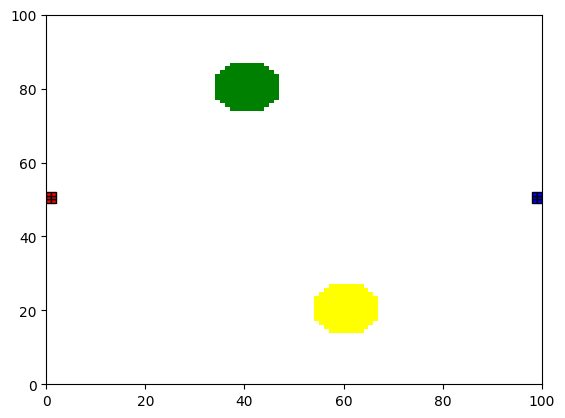

In [85]:
bf = Battlefield(100, 100, 100)
if __name__ == "__main__":
    main(bf)

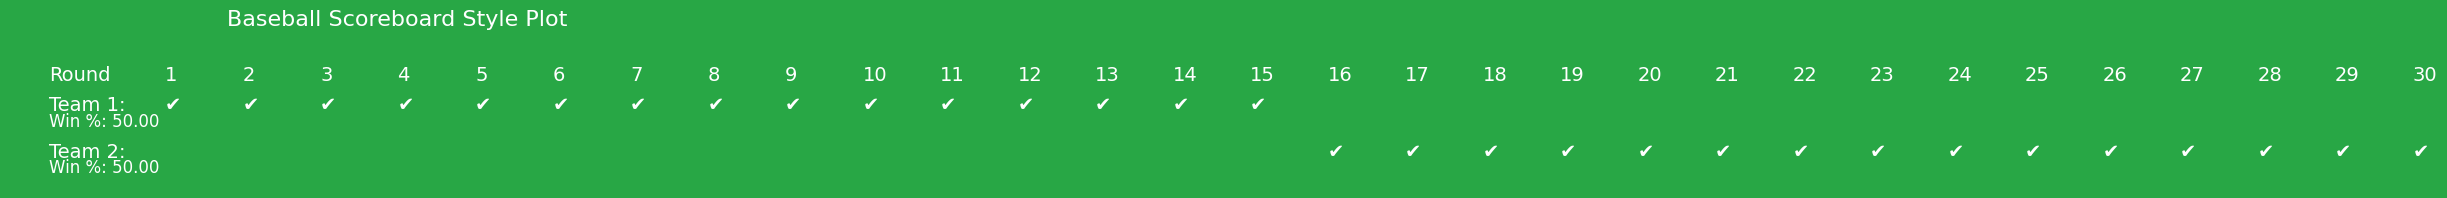

In [78]:
import matplotlib.pyplot as plt

def plot_baseball_scoreboard(round_numbers, team1_rounds_won, team2_rounds_won):
    total_rounds = len(round_numbers)
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(10, 2))
    
    # Set the background color to green
    fig.patch.set_facecolor('#28a745')
    
    # Remove axes
    ax.axis('off')
    
    # Plot the round numbers
    ax.text(0.05, 0.7, 'Round', fontsize=14, color='white')
    for i, round_num in enumerate(round_numbers):
        ax.text(0.2 + i * 0.1, 0.7, str(round_num), fontsize=14, color='white')
    
    # Plot the ticks for Team 1
    ax.text(0.05, 0.5, 'Team 1:', fontsize=14, color='white')
    team1_wins = sum(team1_rounds_won)
    team1_win_percentage = team1_wins / total_rounds * 100
    ax.text(0.05, 0.4, f'Win %: {team1_win_percentage:.2f}', fontsize=12, color='white')
    for i, round_win in enumerate(team1_rounds_won):
        if round_win:
            ax.text(0.2 + i * 0.1, 0.5, '✔', fontsize=14, color='white')
        else:
            ax.text(0.2 + i * 0.1, 0.5, '', fontsize=14, color='white')
    
    # Plot the ticks for Team 2
    ax.text(0.05, 0.2, 'Team 2:', fontsize=14, color='white')
    team2_wins = sum(team2_rounds_won)
    team2_win_percentage = team2_wins / total_rounds * 100
    ax.text(0.05, 0.1, f'Win %: {team2_win_percentage:.2f}', fontsize=12, color='white')
    for i, round_win in enumerate(team2_rounds_won):
        if round_win:
            ax.text(0.2 + i * 0.1, 0.2, '✔', fontsize=14, color='white')
        else:
            ax.text(0.2 + i * 0.1, 0.2, '', fontsize=14, color='white')
    
    # Set the title
    ax.set_title('Baseball Scoreboard Style Plot', fontsize=16, color='white')

    plt.show()

# Example data - replace this with your round numbers and team scores
# Example data with more rounds - replace this with your data
# Example data with 30 rounds
round_numbers = list(range(1, 31))
team1_rounds_won = [1] * 15 + [0] * 15  # Team 1 wins the first 15 rounds, then Team 2 wins the rest
team2_rounds_won = [0] * 15 + [1] * 15

# Plot the scoreboard
plot_baseball_scoreboard(round_numbers, team1_rounds_won, team2_rounds_won)

